<h1 align="center">
	 Optimizations of Grover’s Search algorithm
</h1>

In [ ]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.compiler import transpile
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
device=provider.get_backend('ibmq_16_melbourne')
# Simulator
simulator = Aer.get_backend('qasm_simulator')

In [ ]:
from grover import * # boolean_grover()
%run phase&modified_grover.py # phase_grover()

One of the problems currently faced to implement quantum algorithms is the required number of quantum gates, qubits, and delay for performing any task. Quantum Computers and simulators are still prone to noise and errors. So, we find it necessary to optimize the quantum operations to reduce the necessary number of gates and qubits.


We will implement a Grover diffuser and oracle in the circuit. If we use a multi conditioned qubits gate, when the circuit is transpiled to run on quantum device, there will be a high circuit depth. If we increase that time to do like those jobs by a very long coherence time, all the gates $-$ can be fit. The highest-coherence qubits that we can make today have a coherence time of ~ 100 microseconds. We may also wan to optimize the number of operations we can fit within that time. It is only possible to run Grover's algortigm if we have a low circuit depth

Ancilla qubits can be used to reduce circuit depth. By applying many two-qubits Toffoli gates (`ccx`), we can decompose them to 15 elementary gates, 6 CNOT gates among them, acting just only on the pair of qubits

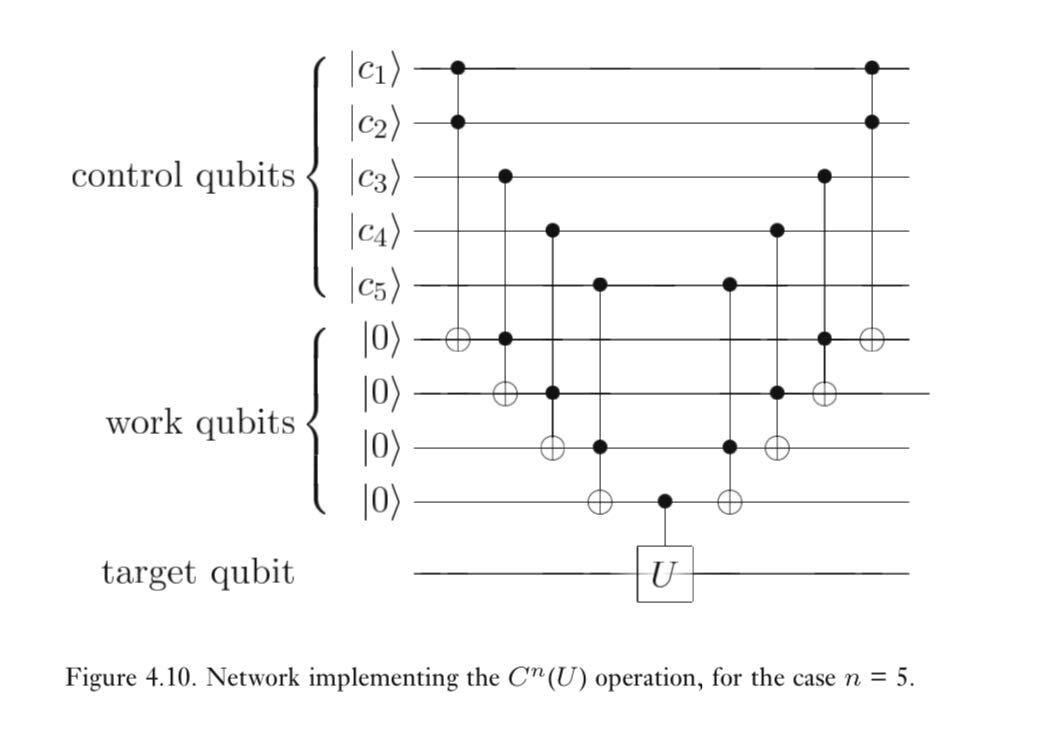

In the diagram we have used many CCNOT gates as ancilla qubit, however the circuit cost is still high, because increasing the number of controlled qubits implies using more ancillas which is still difficult to implement on hardware

So we have to decrease the number of ancillary qubits present in oracle. In the next step, Fig 2 is implemeneted with 9 qubits by implementing phase oracle. We will reduce number of ccx gates by 3.

### -Optimized Oracle:
The number of qubits is reduced by one and this new design is applicable for n multi-qubit control gate.


In [ ]:

s0=boolean_oracle(['11111'], 'ancilla')
s0.draw('mpl')

In [ ]:

s=oracle(['111111'], 'ancilla')
s.draw('mpl')

Using the identity $HXH=Z$, we have implemented the circuit with 2 hadamard gates.

In [ ]:

s1=oracle(['111'], 'ancilla')
s1.draw('mpl')

In [ ]:

s2=boolean_oracle(['111'], 'ancilla')
s2.draw('mpl')

### -The optimized diffuser
In this part we apply a set of operations to transition from a difference of phase (made by the oracle) to a difference of amplitude (inversion about the mean):

   1-Cancel the superposition by a layer of H gate

   2-Multiply the amplitude of the $|0>_n$ state by -1, this is called a mirror operation $M_0=X^{\otimes n} M_1 X^{\otimes n}$.
    
   3-Restoring the superposition by another layer of H gate called $A^\dagger$, which increases the probability of seeing the desired state.
    
The overall effect is $D=-AM_0A^\dagger$ in the standard version of Grover's algorithm $A=H$ whereas in this paper [[1](https://arxiv.org/abs/2005.06468)] they assign to it another operation; whereby their main achievement is a generalization of the inversion about the mean step, thus rather than canceling the superposition they go forward to another state that makes the reflection easier. They succeeded to combine the action of the first layer of step 1 $H^{\otimes n}$ with the first layer of step 2 $X^{\otimes n}$ into a more efficient operator B where the Grover diffuser turn into $D=B^\dagger M_B B$. They supposed an operator B such that $BA=X^{\otimes n}$, then $A^\dagger=X^{\otimes n} B$ and $A=B^\dagger X^{\otimes n}$ then the Grover diffusion becomes: $$\begin{aligned}
D &=A M_{0} A^{\dagger} \\
&=B^{\dagger} X^{\otimes n} M_{0} X^{\otimes n} B \\
&=B^{\dagger} X^{\otimes n} X^{\otimes n} M_{1} X^{\otimes n} X^{\otimes n} B \\
&=B^{\dagger} M_{1} B
\end{aligned}$$
In this case, $M_B=M_1$, which uses fewer gates than $M_0$, therefore avoid the $X$ gates on either side of the multi-control gate. The modified version of the algorithm set $B=R_x(\pi/2)$ and $B^\dagger=R_x(-\pi/2)$; in general this leads to save $2n$ X gates per mirror operation.

Hence the modification is as follow: $HX \rightarrow R_x(\pi/2)$ and $X^\dagger H^\dagger \rightarrow R_x(-\pi/2)$

The preparation layer is also replaced: $H \rightarrow R_x(\pi/2)$

And now let's do a comparison between the boolean Grover's circuit and phase+modified Grover's circuit by evaluating the circuit depth, widht and quantum cost ( this latter is done by the transpiler where it is the procedded step before running the circuit on the quantum hardware, it does 2 main things: 

1-Expresses high-level gate definitions in terms of the basis gates actually supported by the quantum hardware, in this case is the `ibmq_16_melbourne`.

2-Optimizes the code. )

### 1-Phase oracle + new design Grover's circuit evaluation:

In [ ]:
phase=grover(['1111'], 'ancilla',3)
print('Circuit width', phase.width() -4) # the method will compute the classical registers wires+the quantum ones,
                                        #No of quantum registers is 4 less
print('Count of operations', phase.count_ops())
phase.draw('mpl')

In [ ]:
tranpile1= transpile(phase, device)
print('Phase circuit depth = ',tranpile1.depth())
print('Number of operations   ', tranpile1.count_ops())

$\Rightarrow$ The $Circuit\;depth = 336$ and the $Quantum\;cost=305+113+42=460$

### 2-Boolean oracle Grover's circuit evaluation:

In [ ]:
boolean=boolean_grover(['1111'], 'ancilla',3)
print('Circuit width', boolean.width() -4)
print('Count of operations', boolean.decompose().count_ops())
boolean.decompose().draw('mpl')

In [ ]:
transpile2= transpile(boolean, device)
print('Boolean circuit depth = ',transpile2.depth())
print('Number of operations', transpile2.count_ops())

$\Rightarrow$ The $Circuit\;depth = 588$ and the $Quantum\;cost=592+196+63+3=854$

Let's us calculate the difference between the two circuits:

$\Rightarrow$ The $Circuit\;depth\;diff = 588-336=252$, the $Quantum\;cost\;diff=854-460=394$ and the $Circuit\;width\;diff=8-5=3$

**The $Circuit\;depth\;diff$ and the $Quantum\;cost\;diff$ will grow up exponentially with the number of qubits, whereas the $Circuit\;width\;diff$ will be always different by 3 (2 for the case of three qubits) which means that we saved three qubits (two qubits for the case of three qubits) and reduces the number of gates**

In [ ]:

test1=grover(['011'],'ancilla',2)
count1 = execute(test1,simulator).result().get_counts()
print(count1)
plot_histogram(count1,color='limegreen')

In [ ]:

test2=grover(['110010'],'ancilla',6)
count2 = execute(test2,simulator).result().get_counts()
print(count2)
plot_histogram(count2,color='c')

In [ ]:

test3=grover(['11111111', '00000000','01110111'], 'ancilla', 7)
count3 = execute(test3,simulator).result().get_counts()
#print(count3)
plot_histogram(count3,color='yellowgreen')

<h1 align="center">
	References
</h1>
    
[1] [Gilliam, A., Pistoia, M., &amp; Gonciulea, C. (2020, May 26). Optimizing Quantum Search Using a Generalized Version of Grover's Algorithm.](https://arxiv.org/abs/2005.06468)